В цьому домашньому завданні ми проведемо додаткові експерименти для рішення задачі бінарної класифікації і створимо ваш новий submission на змагання на Kaggle.

-----------


**Завдання 0**. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle - шукайте посилання в уроці [Запрошення до участі у Kaggle-змаганні.](https://data-loves.kwiga.com/courses/machine-learning-dlia-liudei/domashnie-zavdannia-zmagannia-z-kaggle)  Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").


**Завдання 1**. **Збираємо весь код з попереднього ДЗ в одному місці.** В лекційному ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb` ми познайомились з поняттям пайплайнів, а також я показала, як компактно виглядає рішення МЛ задачі, якщо ми зберемо весь код разом.

Оскільки ми далі будемо робити експерименти, які включають ті самі етапи попередньої обробки, але інше моделювання - буде зручно мати весь код компактно і під рукою. Тому зараз ми займемось збором коду до купи :) Після цього завдання для подальших експериментів ви можете перенести частини розвʼязку взагалі в окремий `.py` файл, аби було зручно імпортувати функції.

Зі свого рішення в попередньому домашньому завданні (`Логістична регресія з scikit learn.ipynb`) зберіть усі кроки розвʼязку задачі разом з використанням `sklearn.Pipeline` за прикладом з лекції.

Ваш код нижче має містити
1. Читання даних з файлу (поза пайплайном).
2. Розбиття на тренувальний і валідаційний набори, де валідаційний містить 20% даних (поза пайплайном).
3. Виділення категоріальних і числових колонок (поза пайплайном).
4. Підготовку категоріальних і числових колонок (частина пайплайну). В прикладі в лекції ми оформлювали обробку числових і категоріальних колонок в окремі трансформери `numeric_transformer`, `categorical_cols`. Рекоемндую зробити саме так, так потім зручніше вносити зміни :)
5. Тренування лог регресії (частина пайплайну).
6. Запуск пайплайну на тренування на трен. даних (поза пайплайном).
7. Запуск пайплайну на передбачення на трен і вал. даних і вимір метрик якості ROC-AUC + вивдення Confusion Matrix (поза пайплайном).
8. Збереження моделі в формат joblib (поза пайплайном).

Ви це все вже зробили в попереднтьому ДЗ! Тож, тут просто заадча все зібрати разом.

Нижче я додала підказки, що покроково ви маєте зробити. Якщо ви почуваєтесь впевнено, можете видалити ці підказки і реалізувати все самостійно, або ж - просто заповнити пропуски.

Завдання оцінюється в 10 балів. Головний результат - аби код в фіналі був робочий. Бо за не робочий нам гроші ніхто не заплатить :)

Area under ROC score on Train dataset: 0.88%


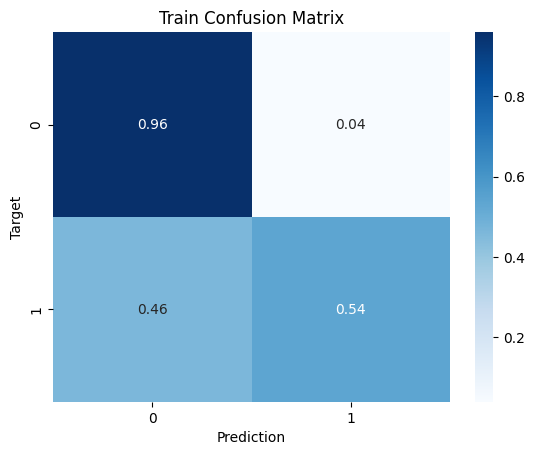

Area under ROC score on Validation dataset: 0.88%


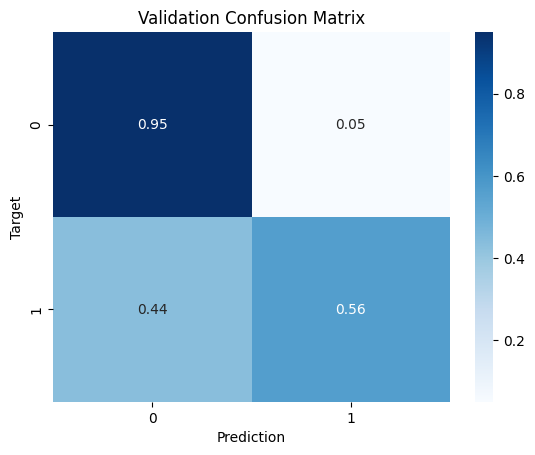

['models/log_reg_pipeline.joblib']

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

random_state = 42
raw_df = pd.read_csv('downloads/train.csv', index_col=0)

train_df, val_df = train_test_split(raw_df, test_size=0.2, random_state=random_state, stratify=raw_df['Exited'])

# Створюємо трен. і вал. набори
target_col = 'Exited'
input_cols = raw_df.columns.drop([target_col, 'CustomerId', 'Surname'])
train_inputs, train_targets = train_df[input_cols], train_df[target_col]
val_inputs, val_targets = val_df[input_cols], val_df[target_col]

# Виявляємо числові і категоріальні колонки
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()

# Створюємо трансформери для числових і категоріальних колонок
numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='if_binary'))
])

# Комбінуємо трансформери для різних типів колонок в один препроцесор
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Стоврюємо пайплайн, який спочатку запускає препроцесинг, потім тренуєм модель
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear'))
])

# Тренуємо пайплайн
model_pipeline.fit(train_inputs, train_targets)

# Функція, щоб передбачати і рахувати метрики
def predict_and_plot(model_pipeline, inputs, targets, name=''):
    preds = model_pipeline.predict(inputs)
    preds_proba = model_pipeline.predict_proba(inputs)[:, 1]
    fpr, tpr, thresholds = roc_curve(targets, preds_proba, pos_label=None)
    roc_auc = auc(fpr, tpr)
    print(f"Area under ROC score on {name} dataset: {roc_auc:.2f}%")
    cm = confusion_matrix(targets, preds, normalize='true')
    plt.figure()
    sns.heatmap(cm, annot=True, cmap='Blues')
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name))
    plt.show()
    return preds

# Оцінюємо модель на трен і вал даних
train_preds = predict_and_plot(model_pipeline, train_inputs, train_targets, name='Train')
val_preds = predict_and_plot(model_pipeline, val_inputs, val_targets, name='Validation')

# Зберігаємо модель для подальшого використання
joblib.dump(model_pipeline, 'models/log_reg_pipeline.joblib')


**Завдання 2**. Такс, у нас з вами є вже готовий пайплайн. Давайте проведемо нові експерименти.

  Додайте в попередню обробку числових колонок генерацію polinomal features до степені 2 включно. Для цього створіть новий препроцесор і створіть новий пайплайн.

  Запустіть пайплайн на тренування і виведіть метрики для тренувального і валідаційного набору. Напишіть, як вам модель? Чи спостерігається в цій моделі overfit чи underfit? Чи ця модель добре генералізує?

Area under ROC score on Train dataset: 0.91%


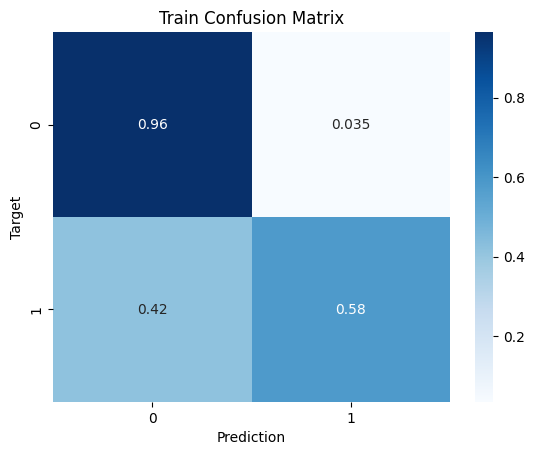

Area under ROC score on Validation dataset: 0.91%


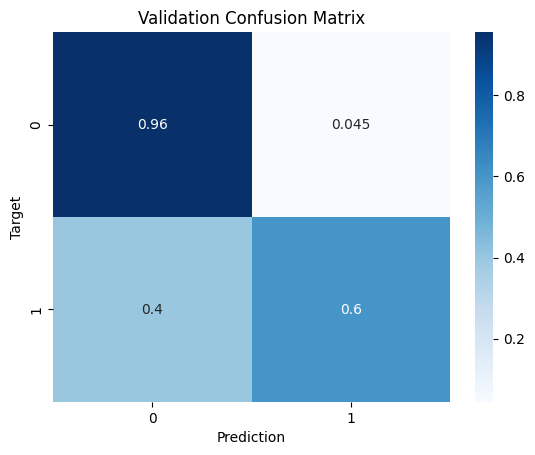

In [2]:
from sklearn.preprocessing import PolynomialFeatures

# Creating transformers for numeric and categorical columns
numeric_transformer = Pipeline(steps=[
    ('polynomial', PolynomialFeatures(degree=2)),
    ('scaler', MinMaxScaler()),
])

# Combine transformers for different types of speakers into one preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Create a pipeline that first runs preprocessing, then trains the model
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear'))
])

# Train pipeline
model_pipeline.fit(train_inputs, train_targets)


train_preds = predict_and_plot(model_pipeline, train_inputs, train_targets, name='Train')
val_preds = predict_and_plot(model_pipeline, val_inputs, val_targets, name='Validation')

<span style="background-color: #f60">Відповідь:</span><br/>
 - Модель з генерацією polinomal features до степені 2 включно дає кращий результат як на тренувальному так і на валідаційному наборі даних, що вказує на те що не спостерігається overfit чи underfit і модель добре генералізує

**Завдання 3**. Тепер давайте створимо ще новий пайплайн, тільки тепер поліноміальні ознаки згенеруємо до степені 4. Зробіть висновок про якість моделі. Якщо вам подобається резульат якоїсь з моделей в цьому ДЗ - рекомендую зробити submission в змаганні.

Area under ROC score on Train dataset: 0.93%


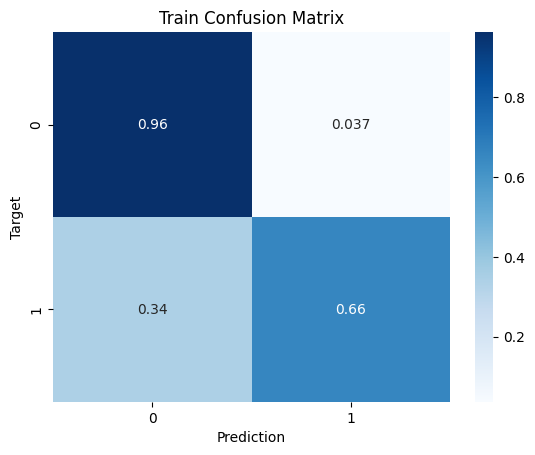

Area under ROC score on Validation dataset: 0.93%


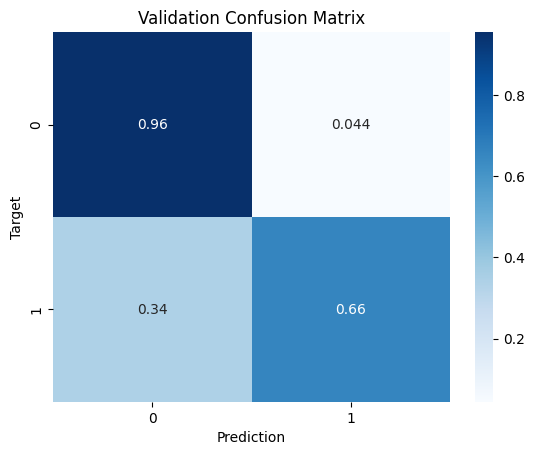

In [3]:
from sklearn.preprocessing import PolynomialFeatures

# Creating transformers for numeric and categorical columns
numeric_transformer = Pipeline(steps=[
    ('polynomial', PolynomialFeatures(degree=4)),
    ('scaler', MinMaxScaler()),
])

# Combine transformers for different types of speakers into one preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Create a pipeline that first runs preprocessing, then trains the model
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear'))
])

# Train pipeline
model_pipeline.fit(train_inputs, train_targets)


train_preds = predict_and_plot(model_pipeline, train_inputs, train_targets, name='Train')
val_preds = predict_and_plot(model_pipeline, val_inputs, val_targets, name='Validation')

<span style="background-color: #f60">Відповідь:</span><br/>
 - Модель з генерацією polinomal features до степені 4 включно все ще дає кращий результат за попредні моделі як на тренувальному так і на валідаційному наборі даних, що вказує на те що не спостерігається overfit чи underfit і модель добре генералізує

**Завдання 4. Перенавчання і регуляризація**.

  Скачайте набір даних `regression_data.csv`. Звичайте набір даних з `regression_data.csv`, розбийте на train і test (в тест 20%) і натренуйте модель лінійної регресії з масштабуванням числових ознак і поліноміальними ознаками до степені **5 включно**.

  Виміряйте якість прогностичної моделі і зробіть висновок, чи модель хороша, чи вона добре генералізує?


In [16]:
rd_df = pd.read_csv('data/regression_data.csv')
display(rd_df.head())
display(rd_df.info())

,feature_1,feature_2,feature_3,feature_4,feature_5,target
0,-0.190339,-1.382800,-0.875618,0.538910,-1.037246,28.938854
1,-0.321386,-0.563725,0.412931,-0.147057,-0.825497,-7.664581
2,2.122156,-1.519370,1.032465,-1.260884,0.917862,-63.845482
3,-1.380101,-0.055548,-1.703382,0.074095,1.628616,4.076259
4,-0.072829,-1.514847,-0.846794,0.714000,0.473238,34.879013


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129 entries, 0 to 128
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   feature_1  129 non-null    float64
 1   feature_2  129 non-null    float64
 2   feature_3  129 non-null    float64
 3   feature_4  129 non-null    float64
 4   feature_5  129 non-null    float64
 5   target     129 non-null    float64
dtypes: float64(6)
memory usage: 6.2 KB


None

In [39]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error

rd_train_df, rd_test_df = train_test_split(rd_df, test_size=0.2, random_state=random_state)

rd_target_col = 'target'
rd_input_cols = rd_df.columns.drop([rd_target_col])
rd_train_inputs, rd_train_targets = rd_train_df[rd_input_cols], rd_train_df[rd_target_col]
rd_test_inputs, rd_test_targets = rd_test_df[rd_input_cols], rd_test_df[rd_target_col]

rd_numeric_transformer_degree5 = Pipeline(steps=[
    ('polynomial', PolynomialFeatures(degree=5)),
    ('scaler', MinMaxScaler())
])

rd_preprocessor_degree5 = ColumnTransformer(
    transformers=[
        ('num', rd_numeric_transformer_degree5, rd_input_cols)
    ])

rd_model_pipeline = Pipeline(steps=[
    ('preprocessor', rd_preprocessor_degree5),
    ('classifier', LinearRegression())
])

rd_model_pipeline.fit(rd_train_inputs, rd_train_targets)

rd_y_pred_train = rd_model_pipeline.predict(rd_train_inputs)
rd_y_pred_test = rd_model_pipeline.predict(rd_test_inputs)

print('Train RMSE: ', round(root_mean_squared_error(rd_train_targets, rd_y_pred_train), 4))
print('Test RMSE: ', round(root_mean_squared_error(rd_test_targets, rd_y_pred_test), 4))


Train RMSE:  0.0
Test RMSE:  12.3633


<span style="background-color: #f60">Відповідь:</span><br/>
 - Для моделі з генерацією polinomal features до степені 5 очевидно спостерігається overfit. Помилка на тренувальному наборі рівна 0, тобто модель повністю завчила тренувальні дані. При цьому модель не здатна до генералізації, про що свідчить високе значення помилки на тестовому наборі

**Завдання 5**. Натренуйте моделі Lasso(), Ridge(), ElasaticNet() на цих даних (з поліном ознаками до степені 20 включно), порівняйте якість з тою, яка була отримана з лінійною регресією. Яка модель найкраще генералізує і чому на ваш погляд (можливо треба буде для відповіді зробити додатковий аналіз ознак)?

In [57]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet

# compare results for PolynomialFeatures degree 2, 5, 20 and linear (degree 1)
rd_numeric_transformer_degree2 = Pipeline(steps=[
    ('polynomial', PolynomialFeatures(degree=2)),
    ('scaler', MinMaxScaler())
])
rd_preprocessor_degree2 = ColumnTransformer(transformers=[
    ('num', rd_numeric_transformer_degree2, rd_input_cols)
])

rd_numeric_transformer_degree20 = Pipeline(steps=[
    ('polynomial', PolynomialFeatures(degree=20)),
    ('scaler', MinMaxScaler())
])
rd_preprocessor_degree20 = ColumnTransformer(transformers=[
    ('num', rd_numeric_transformer_degree20, rd_input_cols)
])

rd_preprocessor_linear = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])
rd_preprocessor_linear = ColumnTransformer(transformers=[
    ('num', rd_preprocessor_linear, rd_input_cols)
])

preprocessors = [
    (rd_preprocessor_linear, 'linear'),
    (rd_preprocessor_degree2, 'degree2'),
    (rd_preprocessor_degree5, 'degree5'),
    (rd_preprocessor_degree20, 'degree20'),
]

# compare results for models
models = [
    LinearRegression(),
    Ridge(),
    Ridge(alpha=0.1),
    Ridge(alpha=0.05),
    Ridge(alpha=0.01),
    Lasso(),
    Lasso(alpha=0.1),
    Lasso(alpha=0.05),
    Lasso(alpha=0.01),
    ElasticNet(),
    ElasticNet(alpha=0.1),
    ElasticNet(alpha=0.05),
    ElasticNet(alpha=0.01),
]


def train_and_evaluate_model(model, preprocessor, X_train, y_train, X_test, y_test):
    rd_model_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    rd_model_pipeline.fit(X_train, y_train)

    y_train_pred = rd_model_pipeline.predict(X_train)
    y_test_pred = rd_model_pipeline.predict(X_test)

    train_metrics = round(root_mean_squared_error(y_train, y_train_pred), 6)
    test_metrics = round(root_mean_squared_error(y_test, y_test_pred), 6)

    return dict(train=train_metrics, test=test_metrics)

results = []

for preprocessor, prep_name in preprocessors:
    for model in models:
        eval_results = train_and_evaluate_model(
            model, preprocessor,
            rd_train_inputs, rd_train_targets,
            rd_test_inputs, rd_test_targets
        )
        results.append({
            "model": str(model),
            "preprocessor": prep_name,
            "train_rmse": eval_results["train"],
            "test_rmse": eval_results["test"]
        })

results_df = pd.DataFrame(results)

results_df.sort_values("test_rmse")


/opt/miniconda3/envs/mlpeople3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.716e+01, tolerance: 2.006e+01
  model = cd_fast.enet_coordinate_descent(


,model,preprocessor,train_rmse,test_rmse
8,Lasso(alpha=0.01),linear,1.071482,0.855292
4,Ridge(alpha=0.01),linear,1.071789,0.872544
0,LinearRegression(),linear,1.066472,0.883327
33,Lasso(alpha=0.05),degree5,1.118275,0.887751
20,Lasso(alpha=0.05),degree2,1.118275,0.887751
7,Lasso(alpha=0.05),linear,1.118275,0.887751
46,Lasso(alpha=0.05),degree20,1.118275,0.887751
21,Lasso(alpha=0.01),degree2,1.045153,0.892677
34,Lasso(alpha=0.01),degree5,0.962527,0.916984
3,Ridge(alpha=0.05),linear,1.189998,0.983642


In [64]:
# check coefs of the best poly features model
poly_features = PolynomialFeatures(degree=5)
X_train_poly = poly_features.fit_transform(rd_train_inputs)

model = Lasso(alpha=0.05)
model.fit(X_train_poly, rd_train_targets)

coefs_df = pd.DataFrame(poly_features.get_feature_names_out(rd_train_inputs.columns), columns=['feature_name'])
coefs_df['value'] = model.coef_.round(5).flatten()
coefs_df.set_index('feature_name').sort_values(by='value', ascending=False).head(10)

,value
feature_name,
feature_4,49.47093
feature_1^2 feature_4 feature_5^2,0.25371
feature_1^3 feature_3 feature_4,0.13286
feature_1 feature_4^4,0.10919
feature_1^2 feature_5^2,0.10215
feature_1^3 feature_3,0.08669
feature_3 feature_4^4,0.07082
feature_2 feature_4 feature_5^3,0.06898
feature_1^2 feature_3^3,0.04196


In [68]:
# check coefs of linear model
poly_features = PolynomialFeatures(degree=1)
X_train_poly = poly_features.fit_transform(rd_train_inputs)

model = LinearRegression()
model.fit(X_train_poly, rd_train_targets)

coefs_df = pd.DataFrame(poly_features.get_feature_names_out(rd_train_inputs.columns), columns=['feature_name'])
coefs_df['value'] = model.coef_.round(5).flatten()
coefs_df.set_index('feature_name').sort_values(by='value', ascending=False).head(10)

,value
feature_name,
feature_4,49.91605
feature_1,0.16337
feature_3,0.04514
1,0.00000
feature_2,-0.00140
feature_5,-0.18792


<span style="background-color: #f60">Відповідь:</span><br/>
- Було натреновано моделі **Lasso, Ridge та ElasticNet** з поліноміальними ознаками до 20 степеня та порівняно їх із **LinearRegression**.
- **Найкращу якість показала модель Lasso (alpha=0.01) з лінійними ознаками** (Test RMSE ≈ 0.86). Вона має невелику різницю між train і test помилками, що свідчить про хорошу здатність до генералізації.
- **LinearRegression та Ridge** показали дуже схожі результати, але не перевершили Lasso. Це означає, що дані мають переважно лінійну залежність.
- Додавання **поліноміальних ознак високого степеня (5 та 20)** призвело до сильного перенавчання: помилка на тренуванні ставала майже нульовою, але значно зростала на тестових даних.
- **Ridge** не зміг повністю вирішити проблему перенавчання, оскільки лише зменшує ваги ознак, але не прибирає їх.
- **Lasso працює краще з великою кількістю ознак**, тому що зануляє неважливі коефіцієнти та фактично виконує відбір ознак.
- **ElasticNet** у цьому експерименті показав найгірші результати, ймовірно через чутливість до гіперпараметрів та надмірну складність простору ознак.
- Загалом експеримент показує, що **ускладнення моделі не покращило прогноз**, а навпаки — погіршило здатність до узагальнення.
- **Додатковий аналіз коефіцієнтів поліноміальної моделі (degree=5)** показав, що один лінійний фактор (`feature_4`) має домінуючий вплив, тоді як більшість складних поліноміальних комбінацій мають дуже малі коефіцієнти. Це підтверджує, що внесок нелінійних взаємодій є обмеженим, а Lasso ефективно відкидає неінформативні ознаки.
**Найкраще генералізує Lasso з невеликою регуляризацією**, оскільки модель залишається достатньо простою та не підлаштовується під шум у даних.
